**Capstone**-Project


FindDefault (Prediction of Credit Card fraud)

A credit card is one of the most used financial products to make online purchases and payments. Though the Credit cards can be a convenient way to manage your finances, they can also be risky. Credit card fraud is the unauthorized use of someone else's credit card or credit card information to make purchases or withdraw cash. It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. The dataset contains transactions made by credit cards in September 2013 by European cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions. We have to build a classification model to predict whether a transaction is fraudulent or not.

In [1]:
# Load Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, f1_score
from sklearn.model_selection import GridSearchCV
import joblib
import pickle
import os


In [7]:
# Load dataset
cdata = pd.read_csv('/content/creditcard.csv')

In [8]:
cdata.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [9]:
# Evaluate number of columns and rows in given dataset

Number_of_row = cdata.shape[0]
Number_of_column = cdata.shape[1]

print('Number of rows in creditcard file     :', Number_of_row)
print('Number of columns in creditcard file  :', Number_of_column)

Number of rows in creditcard file     : 34958
Number of columns in creditcard file  : 31


In [10]:
# Check for null values and duplicates
print("Null values in the dataset:")
print(cdata.isnull().sum())
print("\nDuplicate rows:", cdata.duplicated().sum())

Null values in the dataset:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       1
V20       1
V21       1
V22       1
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64

Duplicate rows: 140


In [11]:

cdata.dropna(inplace=True)

In [12]:
data = cdata.drop_duplicates()


In [13]:
print(cdata.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


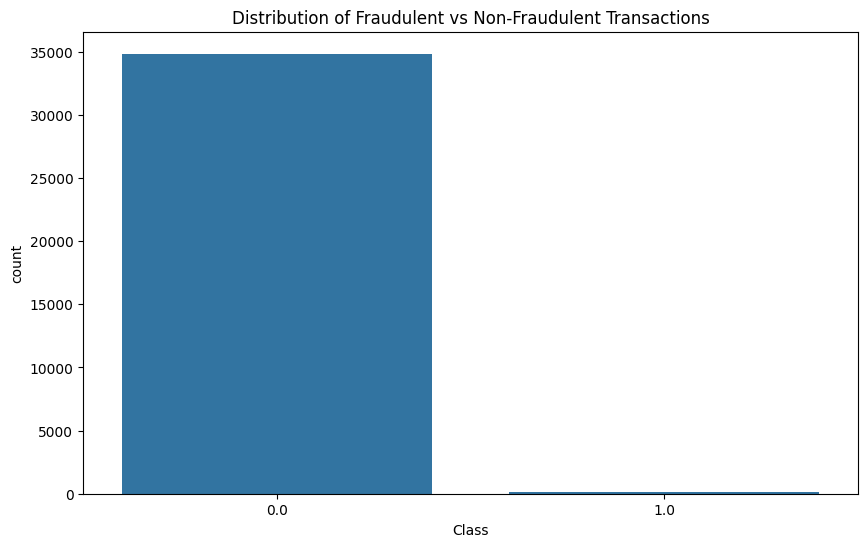

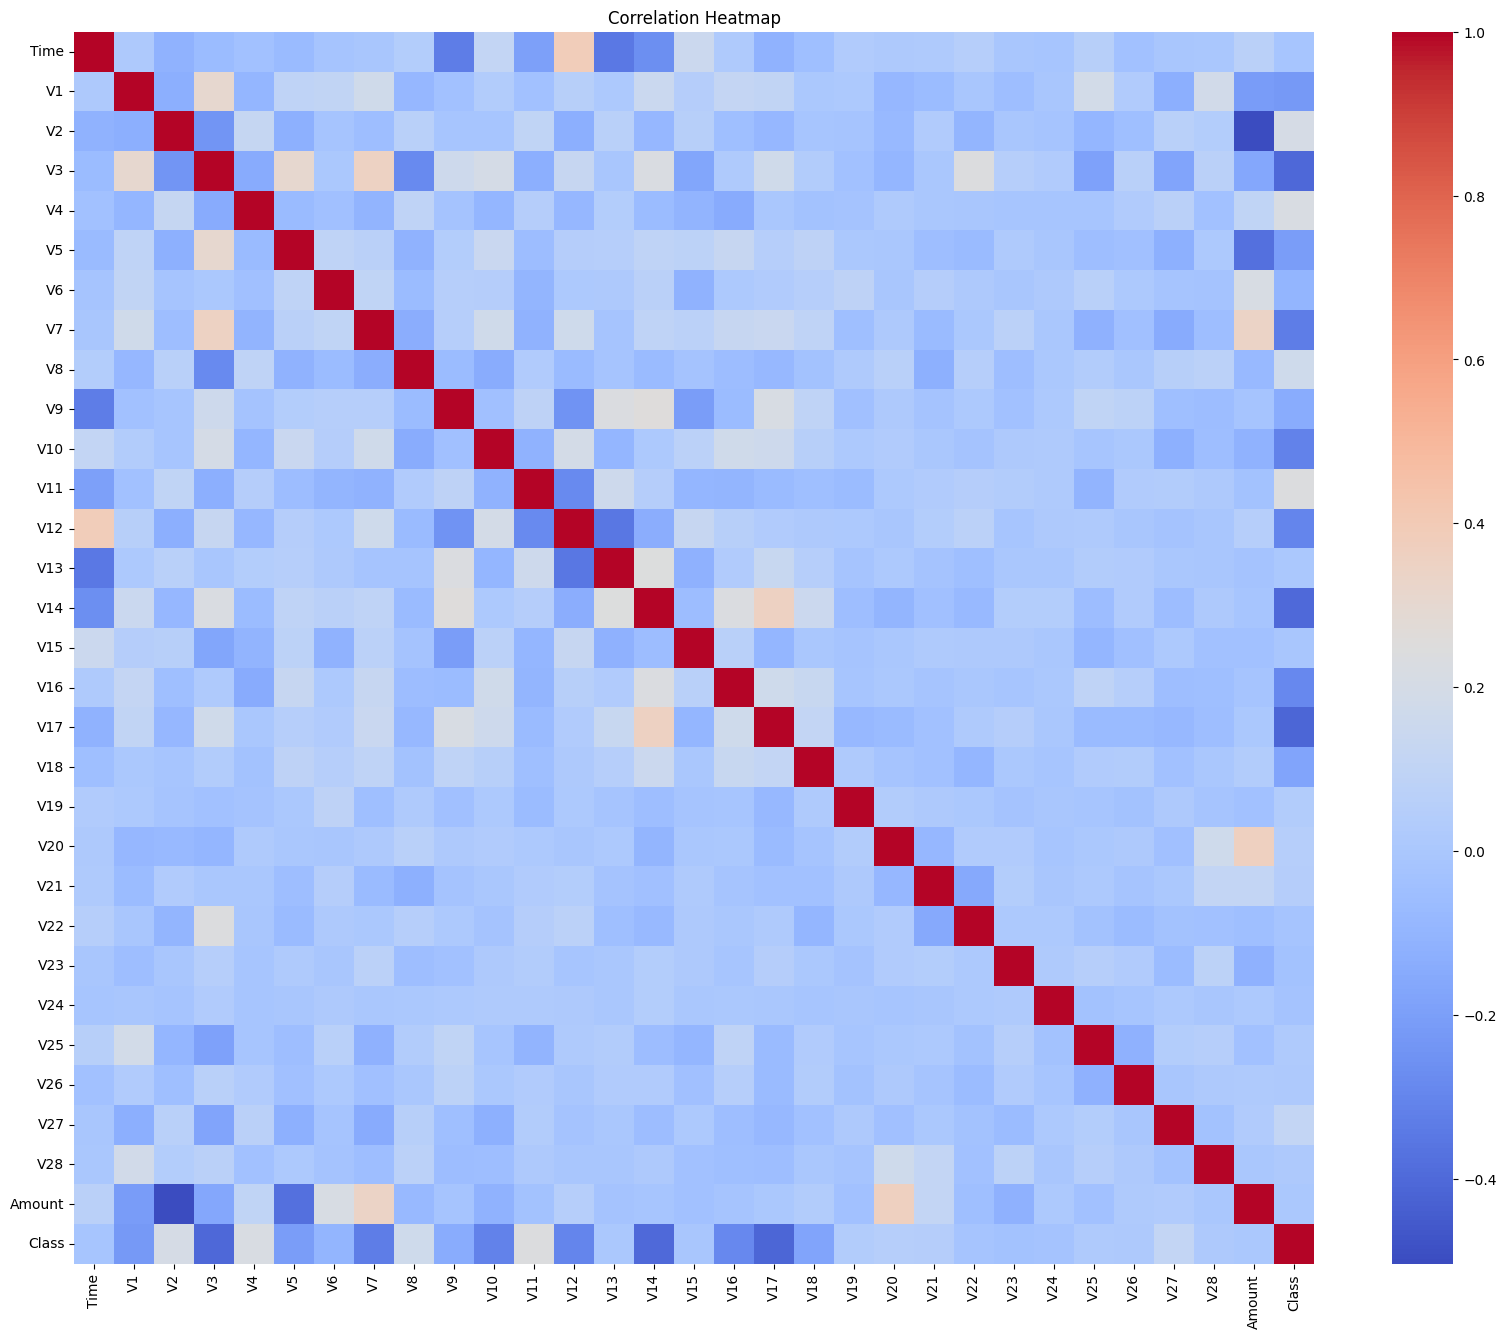

In [14]:
# EDA
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=cdata)
plt.title('Distribution of Fraudulent vs Non-Fraudulent Transactions')
plt.show()

plt.figure(figsize=(20, 16))
sns.heatmap(cdata.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap')
plt.show()


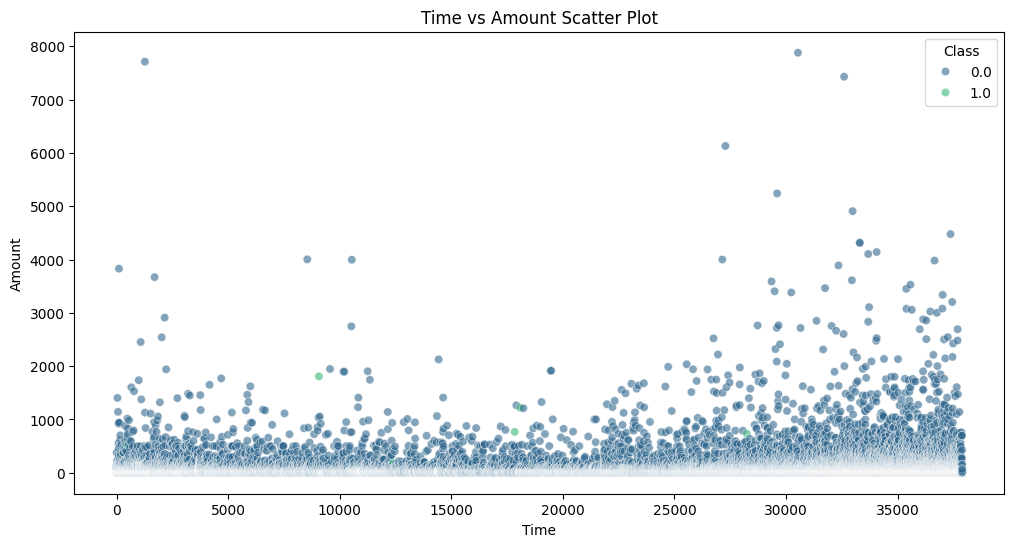

In [15]:
# 1. Time vs Amount scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=cdata, x='Time', y='Amount', hue='Class', palette='viridis', alpha=0.6)
plt.title('Time vs Amount Scatter Plot')
plt.xlabel('Time')
plt.ylabel('Amount')
plt.legend(title='Class')
plt.show()

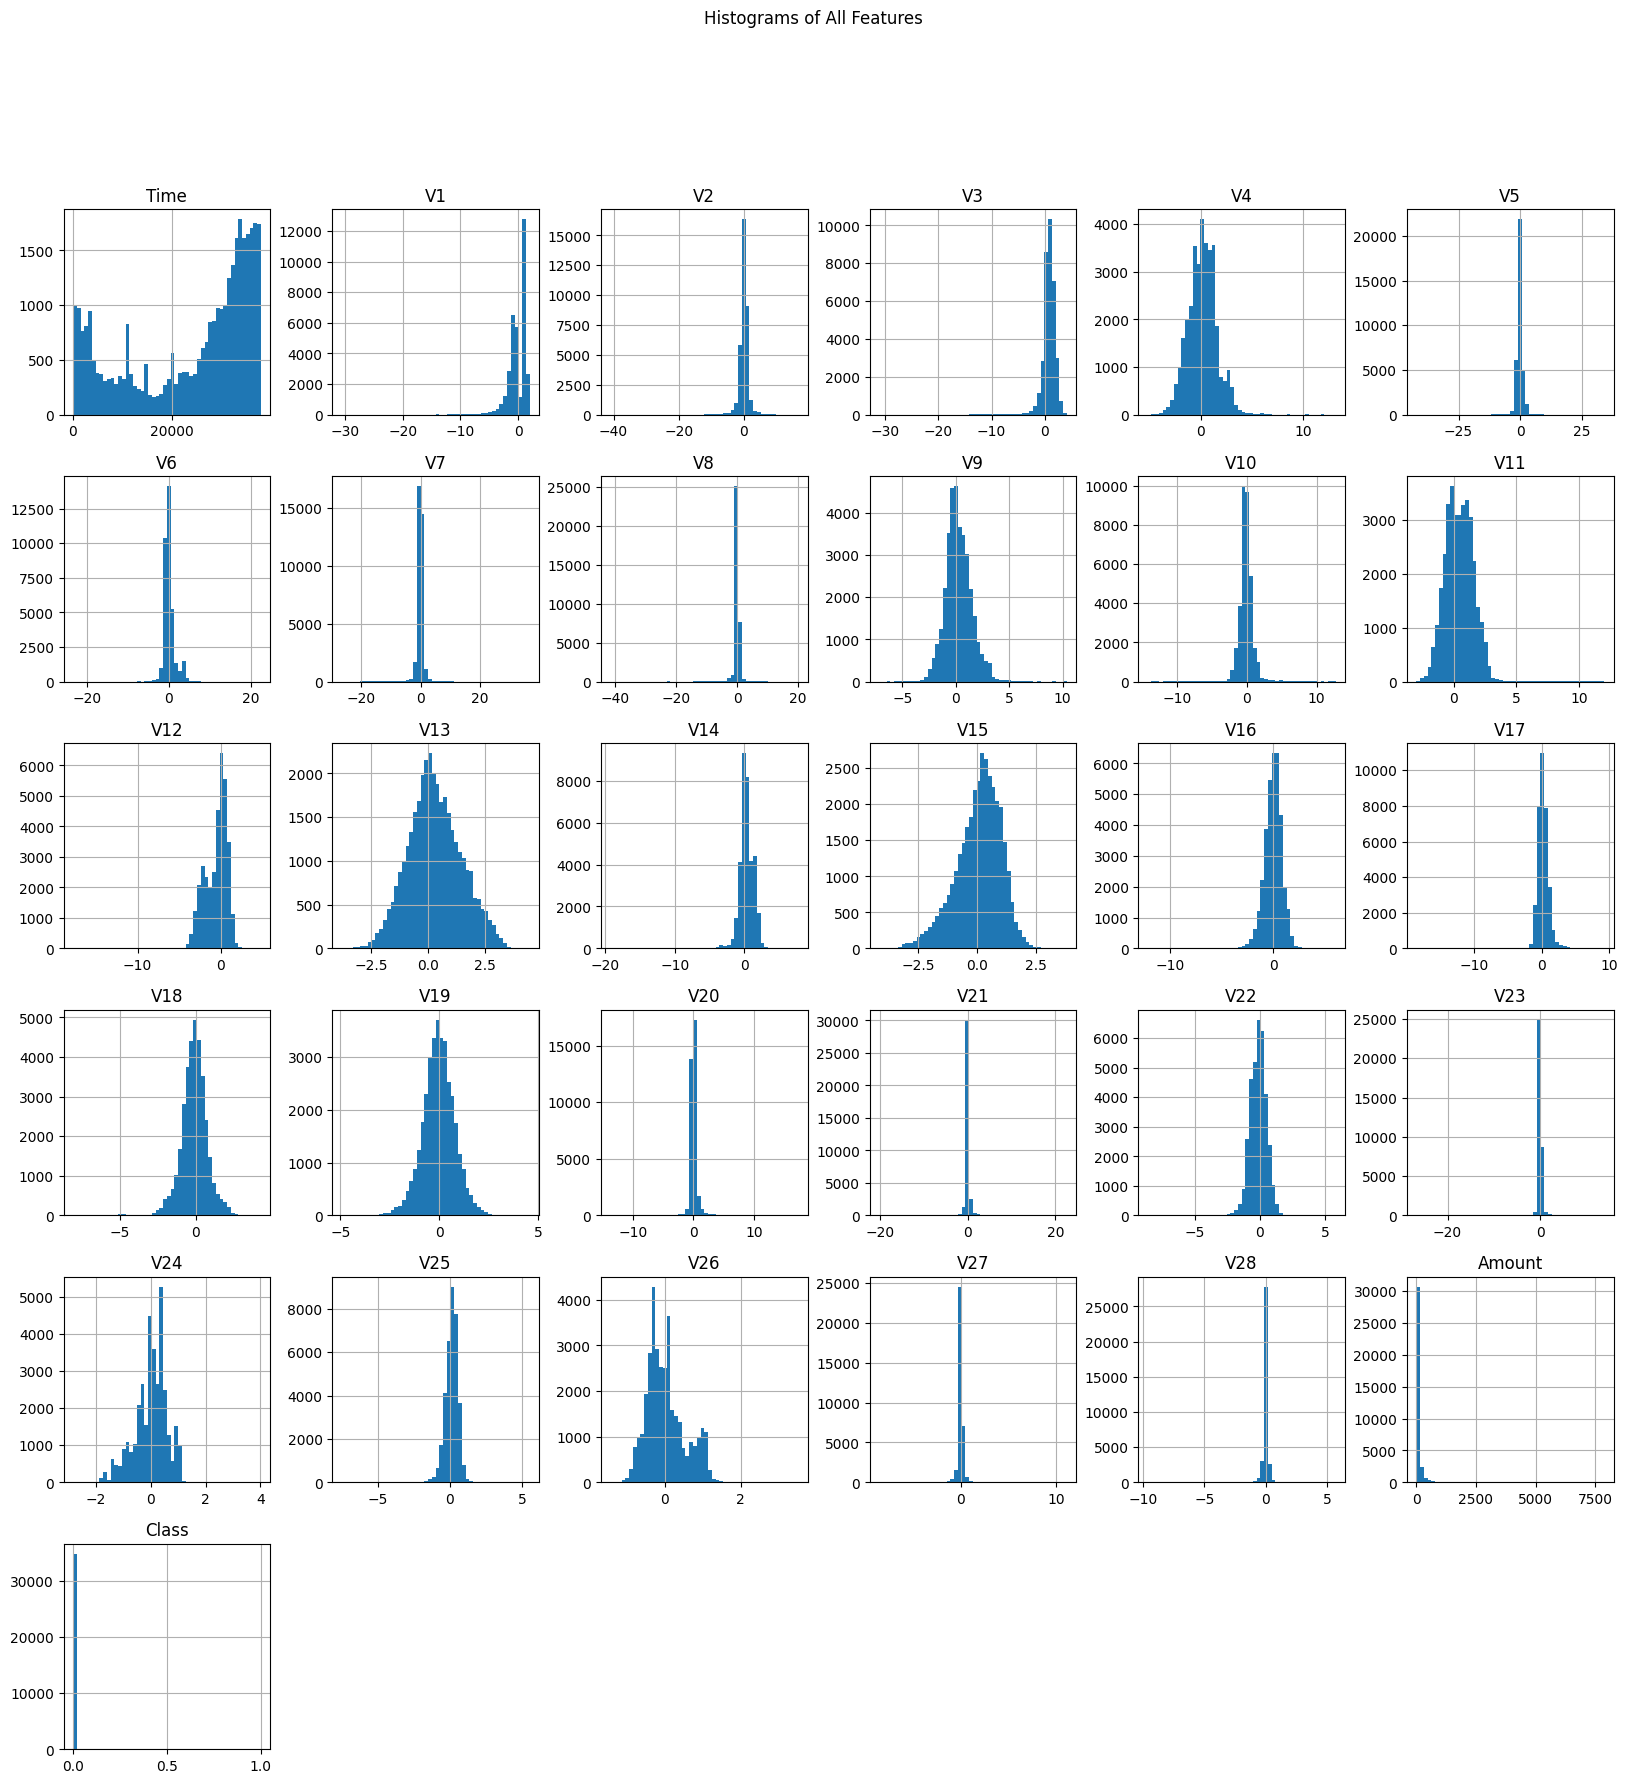

In [16]:
#  Histograms of the features
cdata.hist(figsize=(20, 20), bins=50)
plt.suptitle('Histograms of All Features')
plt.show()

In [17]:
# Separate data of Non-Fraudulent and Fraudulent to check the skewness and kurtosis

Non_Fraudulent= cdata[cdata["Class"] == 0]
print ("Non_Fraudulent:", Non_Fraudulent.shape)
Fraudulent= cdata[cdata["Class"] == 1]
print ("Fraudulent:", Fraudulent.shape)

Non_Fraudulent: (34854, 31)
Fraudulent: (103, 31)


In [18]:
# Separate features and target
X = cdata.drop('Class', axis=1)
y =cdata['Class']

In [19]:
from sklearn.preprocessing import RobustScaler

In [20]:
from sklearn.preprocessing import RobustScaler
import pandas as pd

# Sample DataFrame
data = {'Amount': [10, 20, 30], 'Time': [1, 2, 3]}
input_df = pd.DataFrame(data)

# Define and fit the scaler
scaler = RobustScaler()
scaler.fit(input_df[['Amount', 'Time']])  # Fit to both columns

# Apply scaling
if isinstance(scaler, RobustScaler):
    # Transform the data for both columns and update the DataFrame
    input_df[['Amount', 'Time']] = scaler.transform(input_df[['Amount', 'Time']])


else:
    # Handle unexpected scaler types
    import streamlit as st
    st.error("Unexpected scaler type. Please check your scaler.")

print(input_df)


   Amount  Time
0    -1.0  -1.0
1     0.0   0.0
2     1.0   1.0


In [21]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [22]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)


In [23]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

In [24]:
# Function to evaluate model
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    print(f"\nModel: {model_name}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    avg_precision = average_precision_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Precision-Recall Curve (AP = {avg_precision:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - {model_name}')
    plt.legend()
    plt.show()


In [25]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)


--- Logistic Regression ---


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression (Imbalanced)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.48      0.52      0.50        21

    accuracy                           1.00      6992
   macro avg       0.74      0.76      0.75      6992
weighted avg       1.00      1.00      1.00      6992



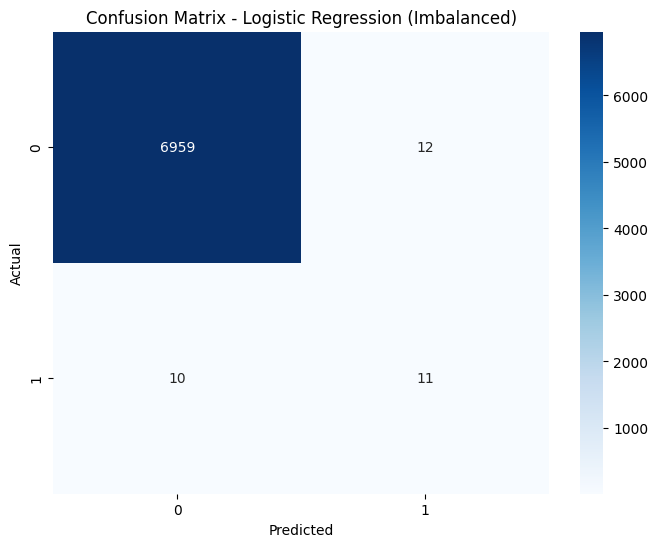

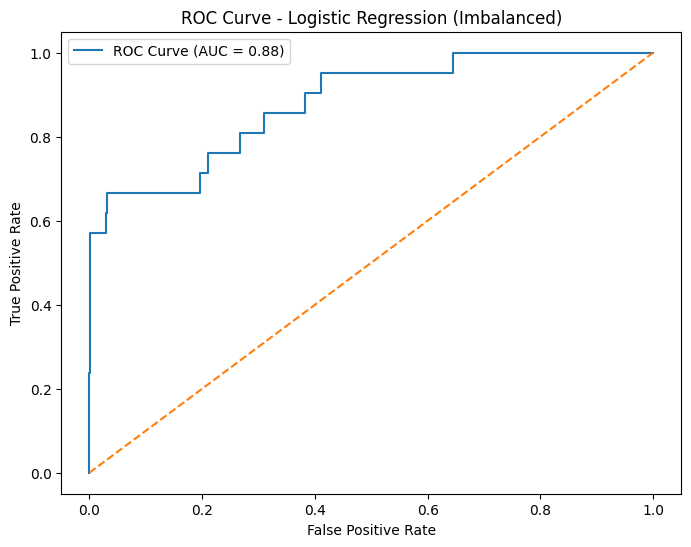

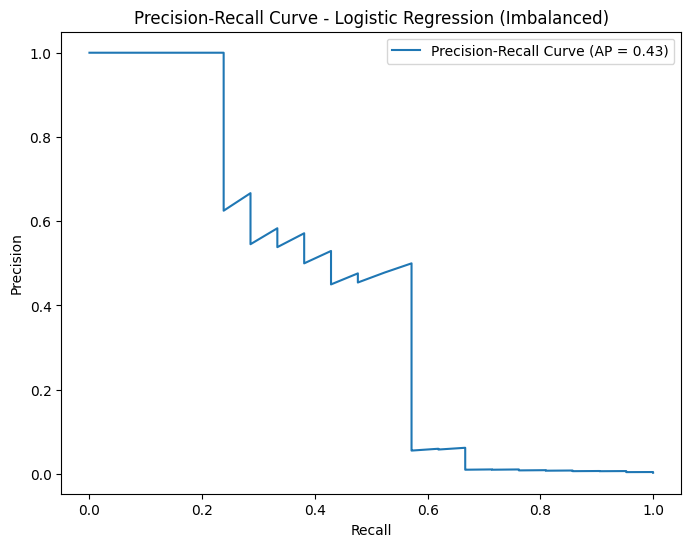

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Model: Logistic Regression (SMOTE)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      6971
         1.0       0.22      0.81      0.34        21

    accuracy                           0.99      6992
   macro avg       0.61      0.90      0.67      6992
weighted avg       1.00      0.99      0.99      6992



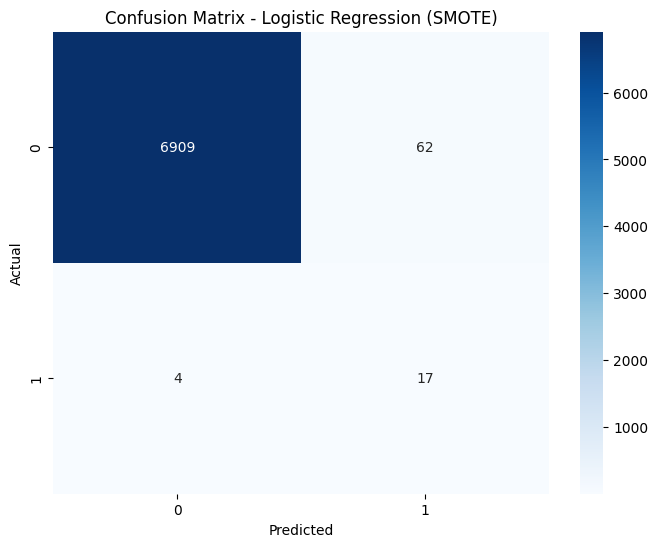

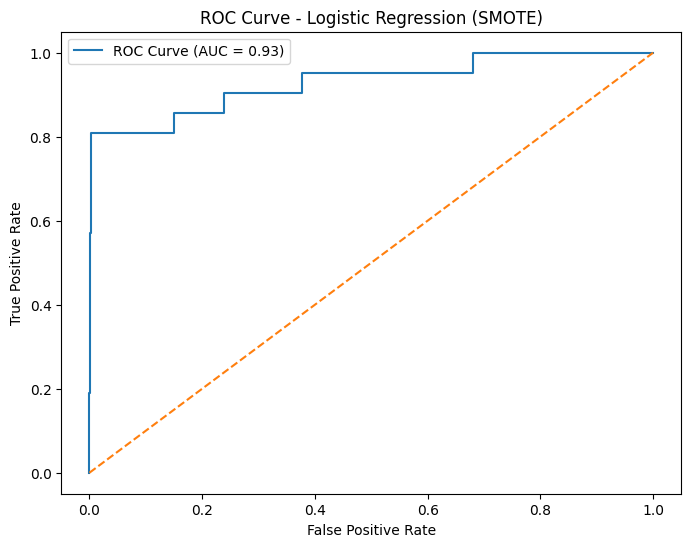

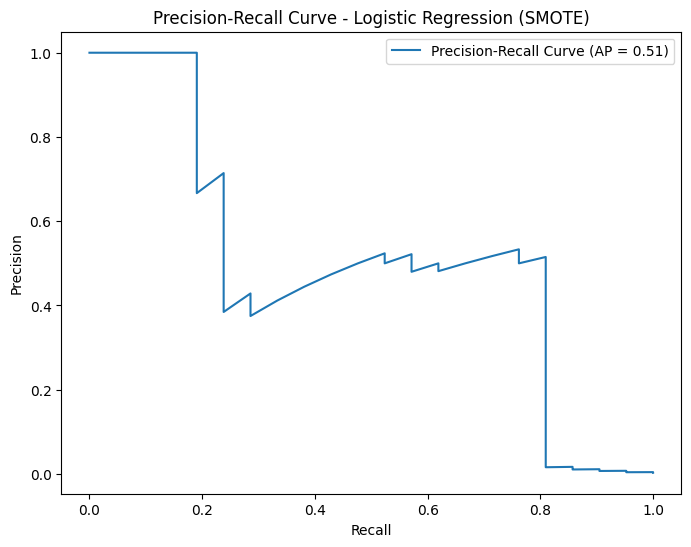


--- Decision Tree ---

Model: Decision Tree (Imbalanced)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.85      0.81      0.83        21

    accuracy                           1.00      6992
   macro avg       0.92      0.90      0.91      6992
weighted avg       1.00      1.00      1.00      6992



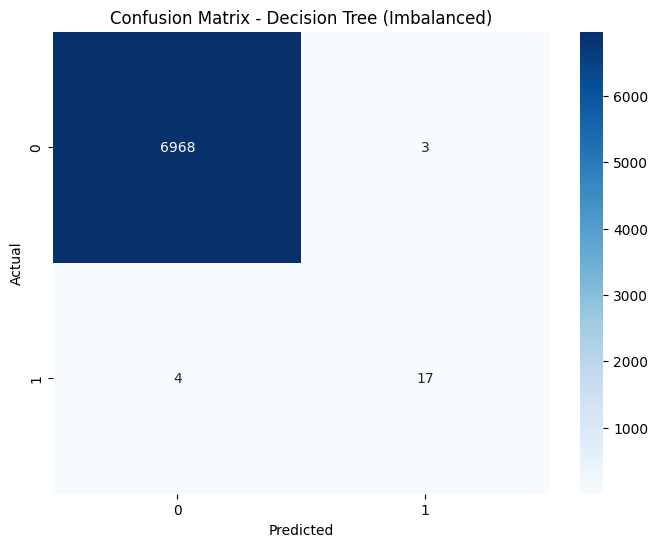

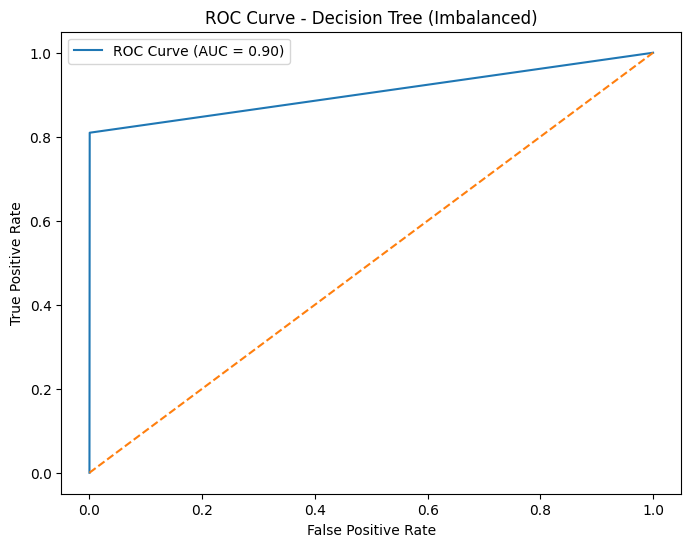

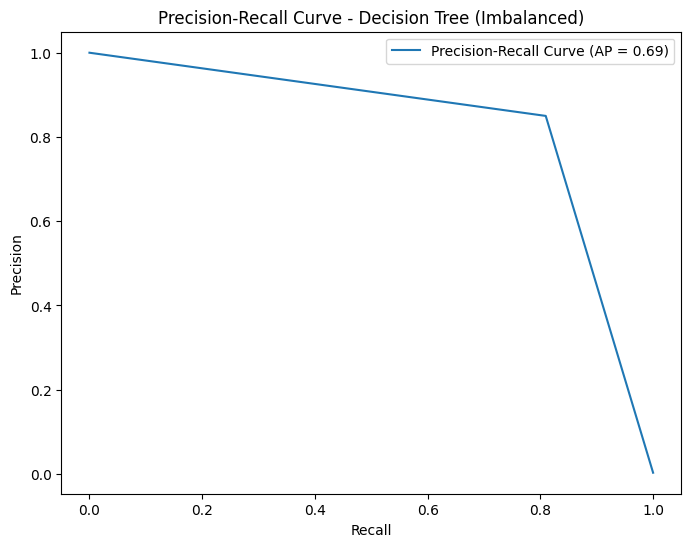


Model: Decision Tree (SMOTE)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.81      0.81      0.81        21

    accuracy                           1.00      6992
   macro avg       0.90      0.90      0.90      6992
weighted avg       1.00      1.00      1.00      6992



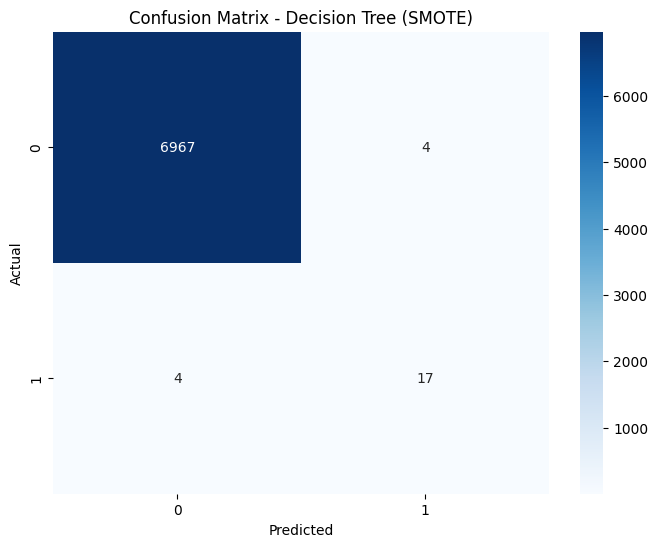

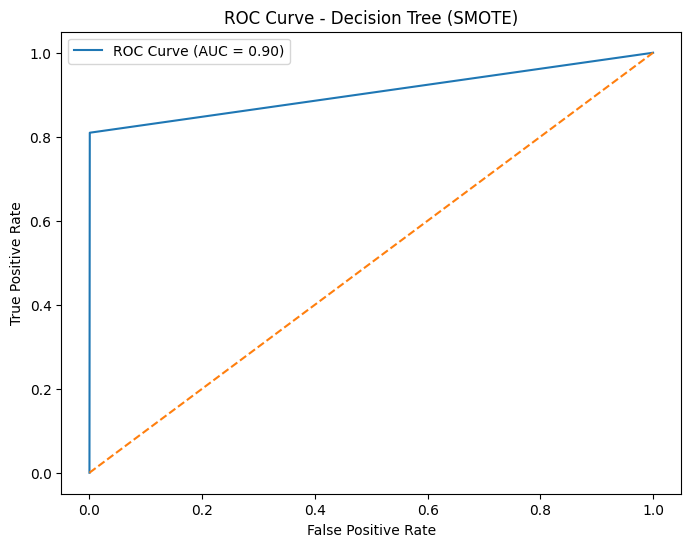

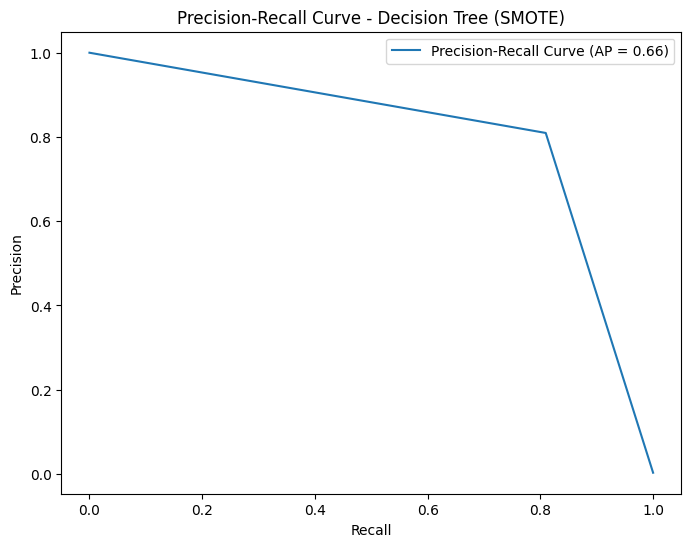


--- Random Forest ---

Model: Random Forest (Imbalanced)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.81      0.62      0.70        21

    accuracy                           1.00      6992
   macro avg       0.91      0.81      0.85      6992
weighted avg       1.00      1.00      1.00      6992



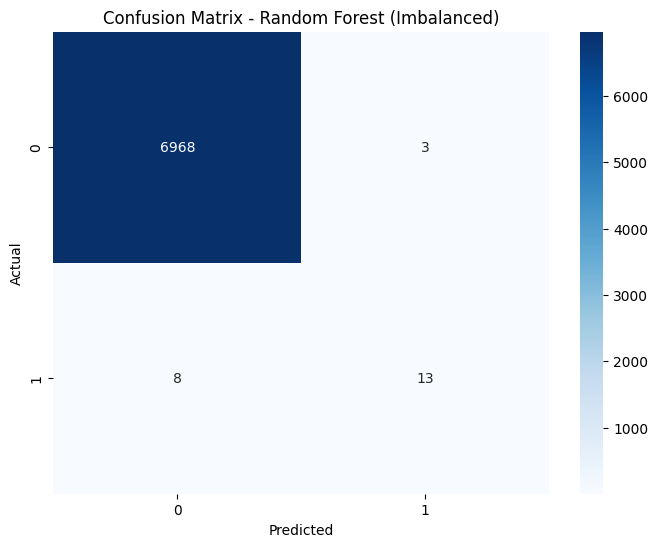

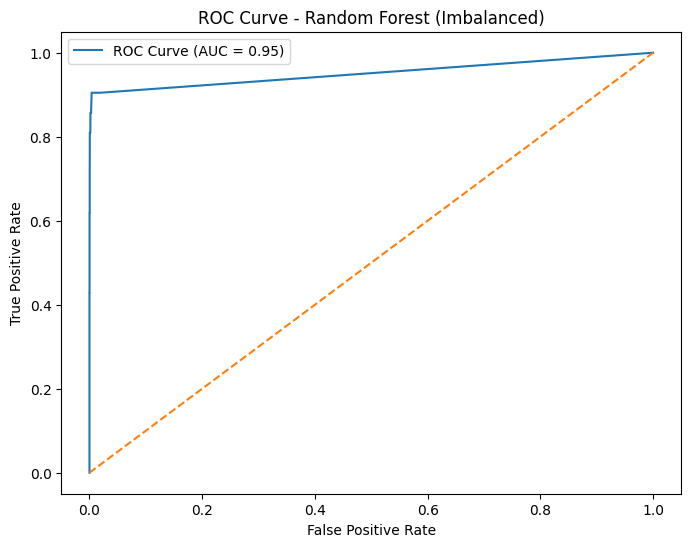

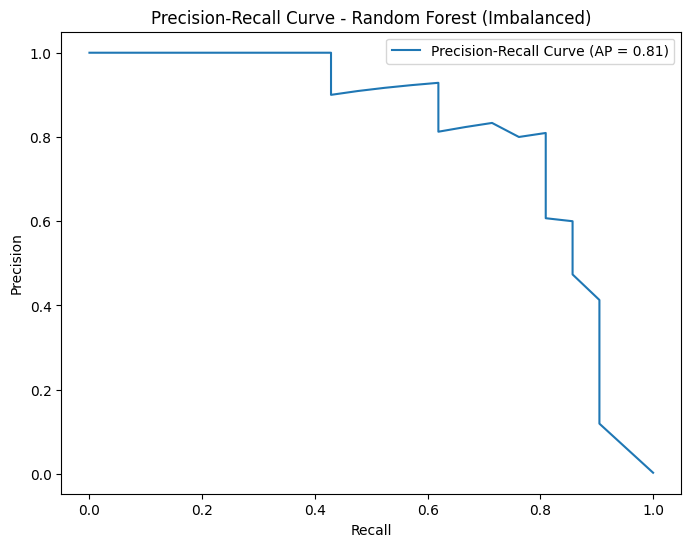


Model: Random Forest (SMOTE)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.89      0.81      0.85        21

    accuracy                           1.00      6992
   macro avg       0.95      0.90      0.92      6992
weighted avg       1.00      1.00      1.00      6992



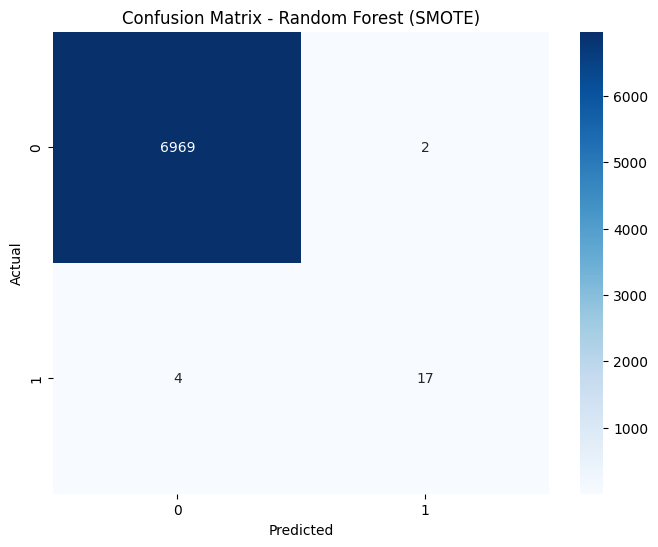

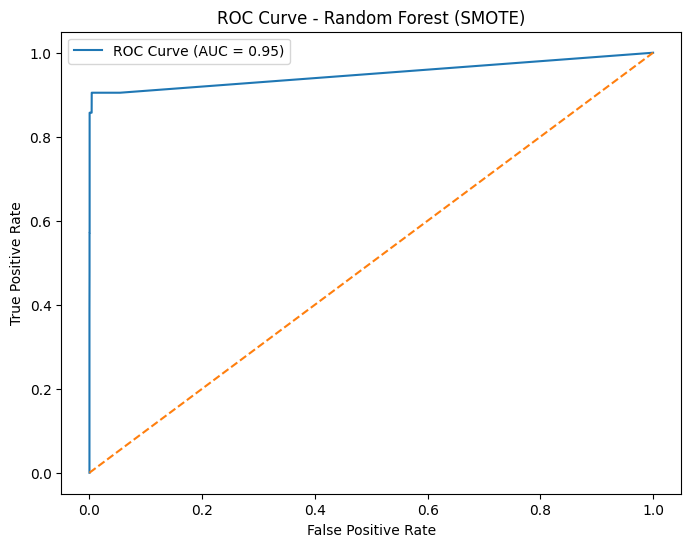

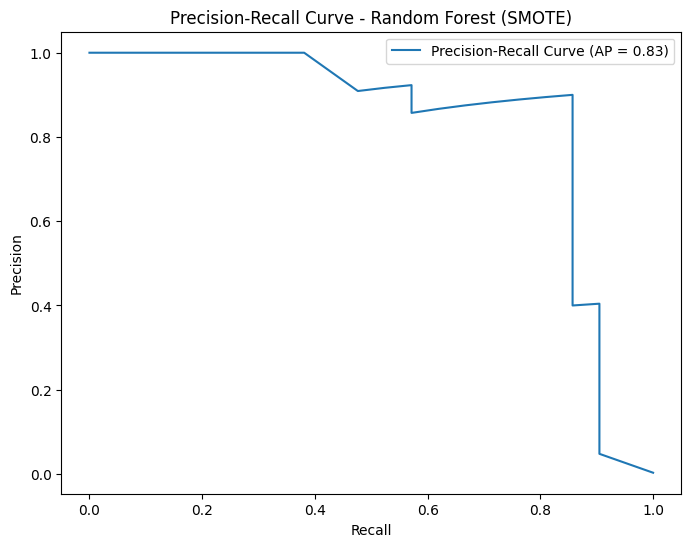


--- XGBoost ---


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:24:42] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost (Imbalanced)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.89      0.76      0.82        21

    accuracy                           1.00      6992
   macro avg       0.94      0.88      0.91      6992
weighted avg       1.00      1.00      1.00      6992



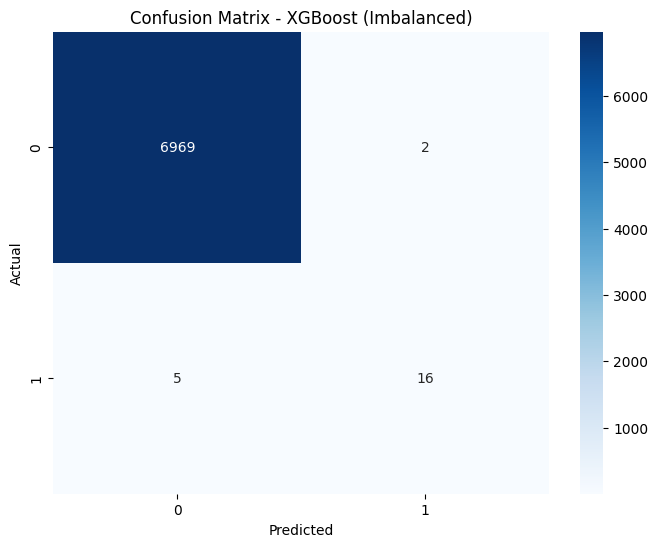

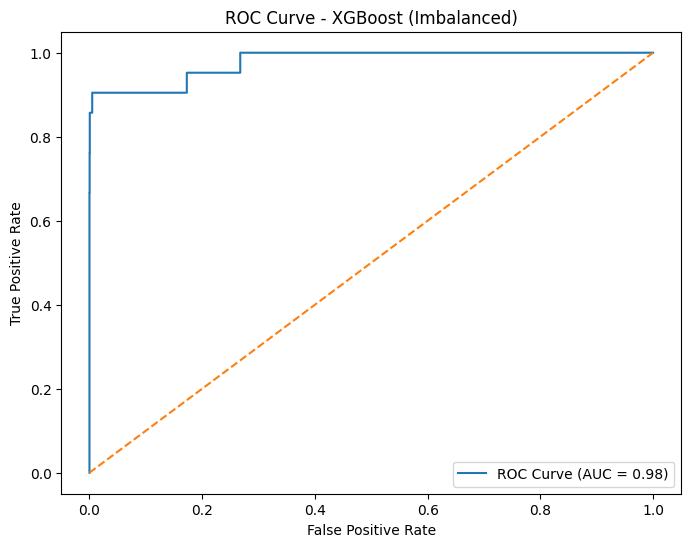

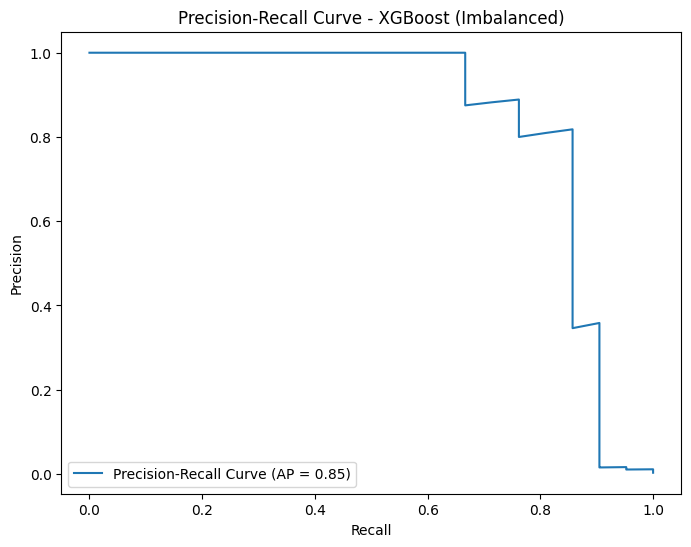

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:24:45] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Model: XGBoost (SMOTE)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.82      0.86      0.84        21

    accuracy                           1.00      6992
   macro avg       0.91      0.93      0.92      6992
weighted avg       1.00      1.00      1.00      6992



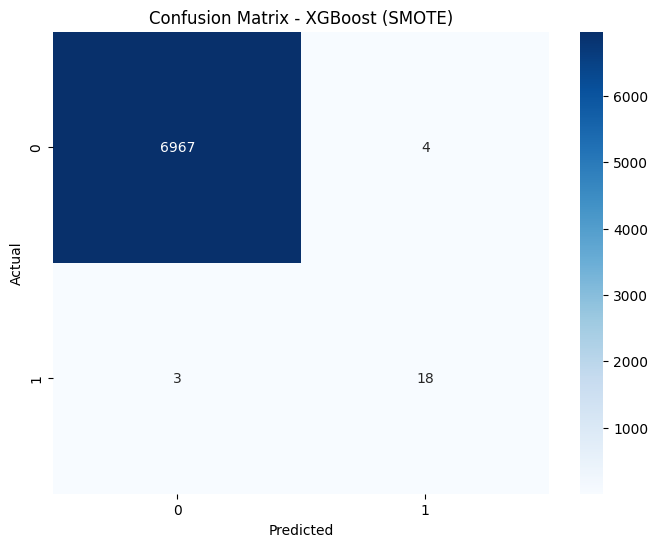

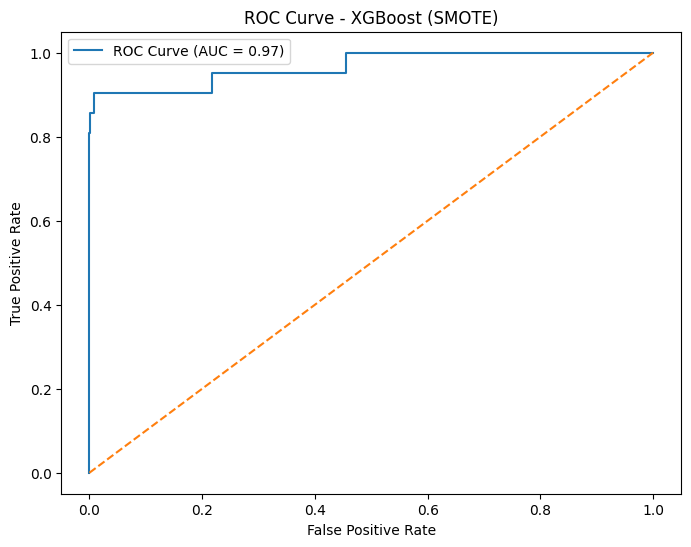

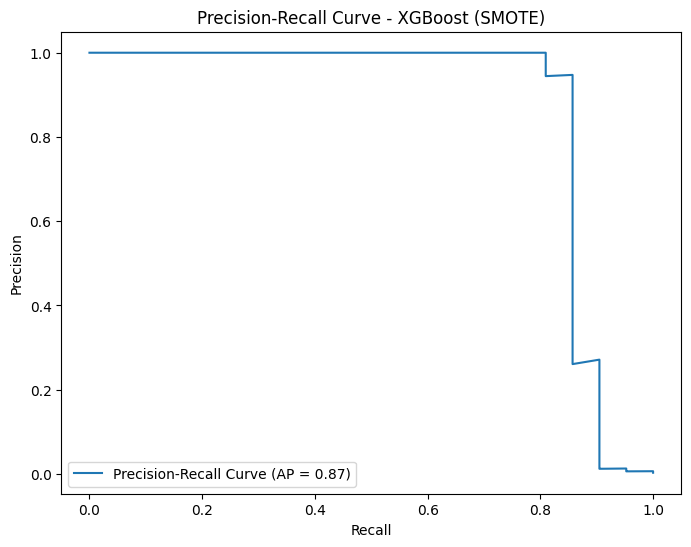

In [26]:
# Train and evaluate models
results = {}

for model_name, model in models.items():
    print(f"\n--- {model_name} ---")

    # Train on imbalanced data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    evaluate_model(y_test, y_pred, y_pred_proba, f"{model_name} (Imbalanced)")

    results[(model_name, 'Imbalanced')] = {
        'auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba)
    }

    # Train on SMOTE-balanced data
    model.fit(X_train_smote, y_train_smote)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    evaluate_model(y_test, y_pred, y_pred_proba, f"{model_name} (SMOTE)")

    results[(model_name, 'SMOTE')] = {
        'auc': roc_auc_score(y_test, y_pred_proba),
        'avg_precision': average_precision_score(y_test, y_pred_proba)
    }

In [27]:
# Print summary of results
print("\n--- Summary of Results ---")
for (model, sampling), metrics in results.items():
    print(f"\n{model} with {sampling}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


--- Summary of Results ---

Logistic Regression with Imbalanced:
auc: 0.8815
avg_precision: 0.4279

Logistic Regression with SMOTE:
auc: 0.9302
avg_precision: 0.5059

Decision Tree with Imbalanced:
auc: 0.9045
avg_precision: 0.6887

Decision Tree with SMOTE:
auc: 0.9045
avg_precision: 0.6559

Random Forest with Imbalanced:
auc: 0.9511
avg_precision: 0.8078

Random Forest with SMOTE:
auc: 0.9495
avg_precision: 0.8274

XGBoost with Imbalanced:
auc: 0.9787
avg_precision: 0.8469

XGBoost with SMOTE:
auc: 0.9676
avg_precision: 0.8685


In [28]:
# Identify best model
best_model = max(results, key=lambda x: results[x]['avg_precision'])
print(f"\nBest Model: {best_model[0]} with {best_model[1]}")
print(f"Average Precision: {results[best_model]['avg_precision']:.4f}")



Best Model: XGBoost with SMOTE
Average Precision: 0.8685


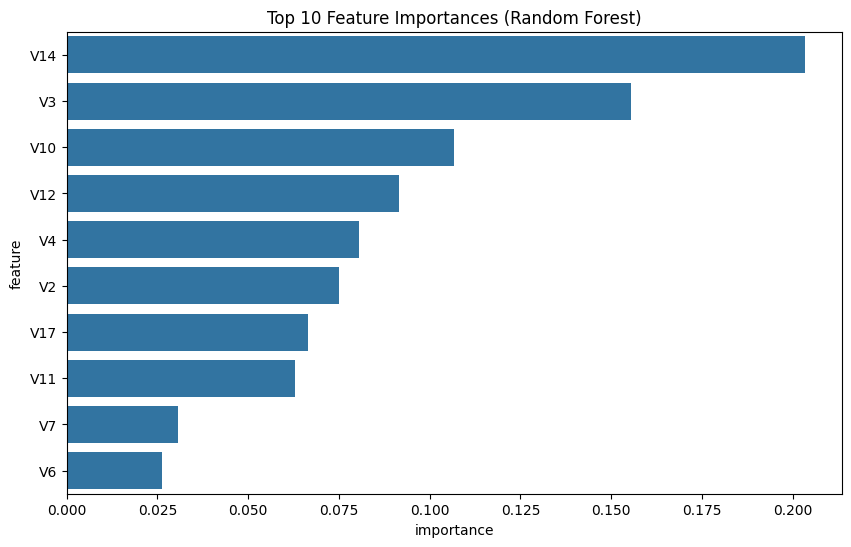

In [29]:
# Feature Importance for Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()


In [30]:
# Threshold Adjustment for best model
best_model_name, best_sampling = best_model
best_model_instance = models[best_model_name]

if best_sampling == 'SMOTE':
    best_model_instance.fit(X_train_smote, y_train_smote)
else:
    best_model_instance.fit(X_train, y_train)

y_pred_proba = best_model_instance.predict_proba(X_test)[:, 1]

thresholds = np.arange(0, 1, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

print(f"\nBest Threshold: {best_threshold:.2f}")
print(f"Best F1-Score: {best_f1:.4f}")

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:25:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Best Threshold: 0.76
Best F1-Score: 0.9000


In [31]:
# Final evaluation with best threshold
y_pred_final = (y_pred_proba >= best_threshold).astype(int)
print("\nFinal Evaluation with Best Threshold:")
print(classification_report(y_test, y_pred_final))


Final Evaluation with Best Threshold:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6971
         1.0       0.95      0.86      0.90        21

    accuracy                           1.00      6992
   macro avg       0.97      0.93      0.95      6992
weighted avg       1.00      1.00      1.00      6992



In [32]:
import pickle

# Save the best model and scaler
model_filename = 'best_fraud_Prediction_model.pkl'  # Model saved as .pkl
scaler_filename = 'scaler.pkl'  # Scaler saved as .pkl


In [33]:
# Save model and scaler using pickle
with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model_instance, model_file)

with open(scaler_filename, 'wb') as scaler_file:
    pickle.dump(scaler, scaler_file)

print(f"Best model saved as {model_filename}")
print(f"Scaler saved as {scaler_filename}")


Best model saved as best_fraud_Prediction_model.pkl
Scaler saved as scaler.pkl


In [34]:



# Load the saved model and scaler using pickle
try:
    with open(model_filename, 'rb') as model_file:
        loaded_model = pickle.load(model_file)
    print("Model loaded successfully from .pkl file")
except Exception as e:
    print(f"Error loading model from .pkl file: {e}")

try:
    with open(scaler_filename, 'rb') as scaler_file:
        loaded_scaler = pickle.load(scaler_file)
    print("Scaler loaded successfully from .pkl file")
except Exception as e:
    print(f"Error loading scaler from .pkl file: {e}")

# Example usage of the loaded model
# predictions = loaded_model.predict(X_test)


Model loaded successfully from .pkl file
Scaler loaded successfully from .pkl file


In [35]:
predictions = loaded_model.predict(X_test)

# Output the predictions
print("Predictions on test data:", predictions)

Predictions on test data: [0 0 0 ... 0 0 0]
